# k-Nearest Neighbor (kNN) exercise

The kNN classifier consists of two stages:

- During training, the classifier takes the training data and simply remembers it
- During testing, kNN classifies every test image by comparing to all training images and transfering the labels of the k most similar training examples
- The value of k is cross-validated

## Packages

In [180]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt
from __future__ import print_function

# This is a bit of magic to make matplotlib figures appear inline in the notebook
# rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load Data

In [181]:
# Load the raw CIFAR-10 data.
cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


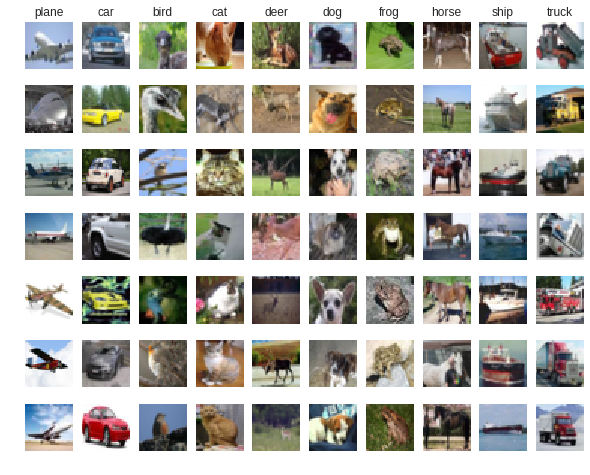

In [182]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [0]:
# Subsample the data for more efficient code execution in this exercise
num_training = 5000
mask = list(range(num_training))
X_train = X_train[mask]
y_train = y_train[mask]

num_test = 500
mask = list(range(num_test))
X_test = X_test[mask]
y_test = y_test[mask]

In [184]:
# Reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
print(X_train.shape, X_test.shape)

(5000, 3072) (500, 3072)


## kNN Classifier

In [0]:
from scipy.stats import mode

class KNearestNeighbor(object):
    """ a kNN classifier with L2 distance """
    def __init__(self):
        pass
    def train(self, X, y):
        """
        Train the classifier. For k-nearest neighbors this is just
        memorizing the training data.

        Inputs:
        - X: A numpy array of shape (num_train, D) containing the training data
            consisting of num_train samples each of dimension D.
        - y: A numpy array of shape (N,) containing the training labels, where
            y[i] is the label for X[i].
        """
        self.Xtr = X
        self.ytr = y

    def predict(self, X, k = 1):
        """
        Predict labels for test data using this classifier.

        Inputs:
        - X: A numpy array of shape (num_test, D) containing test data consisting
            of num_test samples each of dimension D.
        - k: The number of nearest neighbors that vote for the predicted labels.

        Returns:
        - y: A numpy array of shape (num_test,) containing predicted labels for the
            test data, where y[i] is the predicted label for the test point X[i].
        """
        dists = self.compute_distances_no_loops(X)
        return self.predict_labels(dists, k = k)

    def compute_distances_no_loops(self, X):
        """
        Compute the distance between each test point in X and each training point
        in self.X_train using no explicit loops.

        Input / Output: Same as compute_distances_two_loops
        """
        num_test = X.shape[0]
        num_train = self.Xtr.shape[0]
        dists = np.zeros((num_test, num_train))
        
        te = np.sum(X * X, axis = 1, keepdims = True)
        tr = np.sum(self.Xtr * self.Xtr, axis = 1, keepdims = True)
        dists = -2 * np.dot(X, self.Xtr.T) + te + tr.T
        dists = np.sqrt(dists)
        
        return dists

    def predict_labels(self, dists, k = 1):
        """
        Given a matrix of distances between test points and training points,
        predict a label for each test point.

        Inputs:
        - dists: A numpy array of shape (num_test, num_train) where dists[i, j]
            gives the distance between the ith test point and the jth training point.
        Returns:
        - y: A numpy array of shape (num_test,) containing predicted labels for the
           test data, where y[i] is the predicted label for the test point X[i].
        """
        num_test = dists.shape[0]
        y_pred = np.zeros(num_test)
        # ith row of closest_y: k nearest neighbors of the ith testing point
        k_idx = dists.argsort(axis = 1)[:, :k]
        closest_y = self.ytr[k_idx]
        
        # y_pred[i]: the most common label in closest_y[i, :]
        # break ties by choosing the smaller label
        y_pred = np.squeeze(mode(closest_y, axis = 1).mode)
        return y_pred


In [0]:
# Create a kNN classifier instance. 
# Remember that training a kNN classifier is a noop: 
# the Classifier simply remembers the data and does no further processing 
classifier = KNearestNeighbor()
classifier.train(X_train, y_train)

In [210]:
dists = classifier.compute_distances_no_loops(X_test)
print(dists.shape)

(500, 5000)


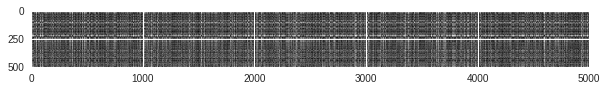

In [211]:
# We can visualize the distance matrix: each row is a single test example and
# its distances to training examples
plt.imshow(dists, interpolation = 'none')
plt.show()

In [212]:
# Now implement the function predict_labels and run the code below:
# We use k = 1 (which is Nearest Neighbor).
y_test_pred = classifier.predict_labels(dists, k = 1)

# Compute and print the fraction of correctly predicted examples
accuracy = np.mean(y_test_pred == y_test)
print('accuracy: %f' % accuracy)

accuracy: 0.274000


In [213]:
y_test_pred = classifier.predict_labels(dists, k=5)
accuracy = np.mean(y_test_pred == y_test)
print('accuracy: %f' % accuracy)

accuracy: 0.278000


## Cross-validation

In [214]:
num_folds = 5
k_choices = [1, 3, 5, 8, 10, 12, 15, 20, 50, 100]

X_train_folds = np.array_split(X_train, num_folds)
y_train_folds = np.array_split(y_train, num_folds)

# A dictionary holding the accuracies for different values of k that we find
# when running cross-validation. After running cross-validation,
# k_to_accuracies[k] should be a list of length num_folds giving the different
# accuracy values that we found when using that value of k.
k_to_accuracies = {}

for k in k_choices:
    accuracies = []
    for i in range(num_folds):
        X, y = X_train_folds[:], y_train_folds[:]
        # validation set
        X_v, y_v = X.pop(i), y.pop(i)
        # training set
        X_tr, y_tr = np.concatenate(X), np.concatenate(y)
        
        # train
        classifier = KNearestNeighbor()
        classifier.train(X_tr, y_tr)
        
        # predict
        y_pred = classifier.predict(X_v, k = k)
        accuracies.append(np.mean(y_pred == y_v))
    k_to_accuracies[k] = accuracies
    
# Print out the computed accuracies
for k in sorted(k_to_accuracies):
    for accuracy in k_to_accuracies[k]:
        print('k = %d, accuracy = %f' % (k, accuracy))

k = 1, accuracy = 0.263000
k = 1, accuracy = 0.257000
k = 1, accuracy = 0.264000
k = 1, accuracy = 0.278000
k = 1, accuracy = 0.266000
k = 3, accuracy = 0.239000
k = 3, accuracy = 0.249000
k = 3, accuracy = 0.240000
k = 3, accuracy = 0.266000
k = 3, accuracy = 0.254000
k = 5, accuracy = 0.248000
k = 5, accuracy = 0.266000
k = 5, accuracy = 0.280000
k = 5, accuracy = 0.292000
k = 5, accuracy = 0.280000
k = 8, accuracy = 0.262000
k = 8, accuracy = 0.282000
k = 8, accuracy = 0.273000
k = 8, accuracy = 0.290000
k = 8, accuracy = 0.273000
k = 10, accuracy = 0.265000
k = 10, accuracy = 0.296000
k = 10, accuracy = 0.276000
k = 10, accuracy = 0.284000
k = 10, accuracy = 0.280000
k = 12, accuracy = 0.260000
k = 12, accuracy = 0.295000
k = 12, accuracy = 0.279000
k = 12, accuracy = 0.283000
k = 12, accuracy = 0.280000
k = 15, accuracy = 0.252000
k = 15, accuracy = 0.289000
k = 15, accuracy = 0.278000
k = 15, accuracy = 0.282000
k = 15, accuracy = 0.274000
k = 20, accuracy = 0.270000
k = 20, accu

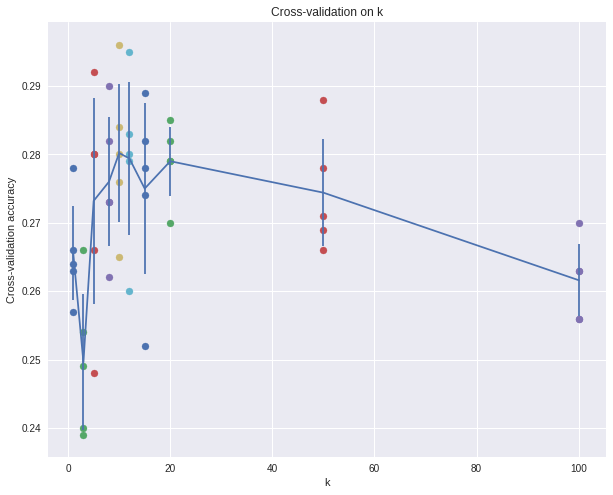

In [215]:
# plot the raw observations
for k in k_choices:
    accuracies = k_to_accuracies[k]
    plt.scatter([k] * len(accuracies), accuracies)

# plot the trend line with error bars that correspond to standard deviation
accuracies_mean = np.array([np.mean(v) for k, v in sorted(k_to_accuracies.items())])
accuracies_std = np.array([np.std(v) for k, v in sorted(k_to_accuracies.items())])
plt.errorbar(k_choices, accuracies_mean, yerr = accuracies_std)
plt.title('Cross-validation on k')
plt.xlabel('k')
plt.ylabel('Cross-validation accuracy')
plt.show()

In [216]:
# Based on the cross-validation results above, choose the best value for k,   
# retrain the classifier using all the training data, and test it on the test
# data. You should be able to get above 28% accuracy on the test data.
best_k = 10

classifier = KNearestNeighbor()
classifier.train(X_train, y_train)
y_test_pred = classifier.predict(X_test, k = best_k)

# Compute and display the accuracy
accuracy = np.mean(y_test_pred == y_test)
print('accuracy: %f' % accuracy)

accuracy: 0.282000
